# 1. Imports and Loading the Network

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import networkx as nx
import pandas as pd
import numpy as np

In [2]:
G = nx.read_edgelist("data/sbb.edgelist", delimiter=";", create_using=nx.Graph)

connected_comp = nx.connected_components(G)
max_connected_comp = max(connected_comp)
G = G.subgraph(max_connected_comp)

# 2. Benchmark: Iteration Time, Silhouette Index and Modularity

In [3]:
from sklearn.metrics import silhouette_score
import time
import os

# create directory to save benchmarks results
if not os.path.exists("data/benchmarks"):
    os.makedirs("data/benchmarks")

# iteration benchmarking function
# you must give it a partition scheme before entering the function
# time_threshold is the maximum number of hours the benchmark should run for. Useful for Girvan-Newman
def iter_benchmark(G, partitions, time_threshold=12, leiden=False):
    timeout = time.time() + 60 * 60 * time_threshold

    i_time = []
    i_silhouette = []
    i_modularity = []
    
    while True:
        # Timeout necessary for Girvan Newman
        if time.time() > timeout:
            break
            
        start = time.time()
        communities = next(partitions, 'finished')
        stop = time.time()
        
        if communities == 'finished':
            break
        
        time_diff = stop - start
        i_time.append(time_diff)

        # Necessary for leiden: convert node ids to node names
        if leiden == True:
            communities = convert_leiden(G, communities)
        
        i_silhouette.append(silhouette_fn(G, communities))
        i_modularity.append(nx.community.modularity(G, communities))
        
        final_communities = communities
        
    return i_time, i_silhouette, i_modularity

# scoring function. Uses silhouette score
def silhouette_fn(G, found_communities, verbose=False):
    # make a dictionary with node as key and final community as value
    node_to_community = {node: comm_idx for comm_idx, community in enumerate(found_communities) for node in community}
    # list all final communities by indexing with keys
    comm_labels = [node_to_community[node] for node in G.nodes()]
    # # turn graph into numpy adjacency matrix
    matrix = nx.to_numpy_array(G)
    # calc silhouette score by inputting graph as an array and the communities as labels
    sil_score = silhouette_score(nx.to_numpy_array(G), comm_labels, metric='euclidean', random_state=42)
    if verbose:
        print("Silhouette Score:", sil_score)
    return sil_score

## 2.1 Louvain

In [4]:
louvain_partitions = nx.community.louvain_partitions(G)
t, s, m = iter_benchmark(G, louvain_partitions)

louvain_bench = pd.DataFrame(zip(t, s, m), columns=["time", "silhouette", "modularity"])
louvain_bench.to_csv("./data/benchmarks/louvain.csv", index=False)

## 2.2 Girvan-Newman

In [ ]:
gn_partitions = nx.community.girvan_newman(G)
t, s, m = iter_benchmark(G, gn_partitions, time_threshold=8)

gn_bench = pd.DataFrame(zip(t, s, m), columns=["time", "silhouette", "modularity"])
gn_bench.to_csv("./data/benchmarks/girvan-newman.csv", index=False)

## 2.3 Leiden

In [5]:
import leidenalg as la
import igraph as ig


def convert_leiden(G, partition):
    idx2name = {idx: name for idx, name in enumerate(list(G.nodes))}
    
    communities = []
    for comm in partition:
        communities.append({idx2name[n] for n in comm})
        
    return communities


def leiden_gen(G):
    graph = ig.Graph.from_networkx(G, vertex_attr_hashable='name')

    # create the partition with every node as its community
    partition = la.ModularityVertexPartition(graph)
    optimiser = la.Optimiser()
        
    diff = 1
    while diff > 0:
        diff = optimiser.optimise_partition(partition)
        yield partition

In [6]:
leiden_partitions = leiden_gen(G)
t, s, m = iter_benchmark(G, leiden_partitions, leiden=True)

leiden_bench = pd.DataFrame(zip(t, s, m), columns=["time", "silhouette", "modularity"])
leiden_bench.to_csv("./data/benchmarks/leiden.csv", index=False)

# 3. Evaluation of the Community Detection Algorithms

In [7]:
def plot_bench_results(df_list, labels):
    fig, axs = plt.subplots(nrows=1, ncols=len(df_list[0].columns), figsize=(18, 6), layout="tight")
    # iterate over the columns
    for i, col in enumerate(df_list[0].columns):
        # iterate over the dataframe: all in the same plot
        for df, label in zip(df_list, labels):
            axs[i].plot(df[col], label=label)
        
        axs[i].set_xlabel('Iteration')
        axs[i].set_ylabel(col)
        axs[i].set_title(f'{col} v. Iteration')
            # force int on x-axis
        axs[i].xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
        axs[i].legend()
    
    plt.show()

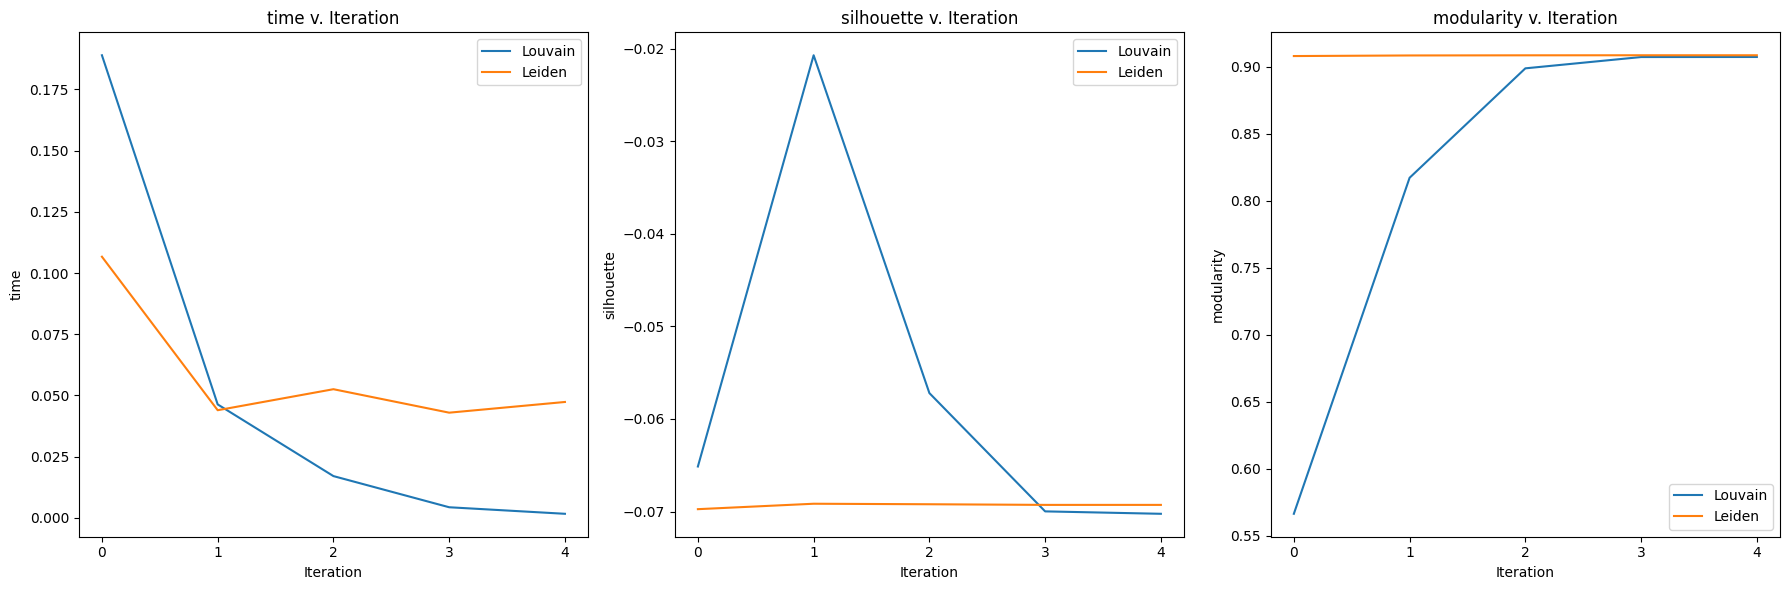

In [8]:
louvain_bench = pd.read_csv("data/benchmarks/louvain.csv")
#gn_bench = pd.read_csv("data/benchmarks/girvan-newman.csv")
leiden_bench = pd.read_csv("data/benchmarks/leiden.csv")

plot_bench_results([louvain_bench, leiden_bench], ["Louvain", "Leiden"])

In [ ]:
# we should be able to safely remove this
# kept just in case
def eval_plots(*datasets, tick_int):
    for i, (data, label, ylabel) in enumerate(datasets):
        for d, l in zip(data, label): 
            ax[i].plot(d, label=l)
        ax[i].set_xlabel('Iterations')
        ax[i].set_ylabel(ylabel)
        ax[i].set_title(f'{ylabel} vs Iterations')
        ax[i].xaxis.set_major_locator(ticker.MultipleLocator(tick_int))
        ax[i].legend()
        
    plt.tight_layout()
    plt.show()

# read nx louvain csvs
nx_lou_times = pd.read_csv("data/communities/nx_louvain_iteration_times.csv")
nx_lou_m_times = nx_lou_times.mean(axis='rows')

nx_lou_sil = pd.read_csv("data/communities/nx_louvain_silhouette_scores_per_iteration.csv")
nx_lou_m_sil = nx_lou_sil.mean(axis='rows')

nx_lou_mod = pd.read_csv("data/communities/nx_louvain_modularity_scores_per_iteration.csv")
nx_lou_m_mod = nx_lou_mod.mean(axis='rows')

# read nx gn csvs
nx_gn_times = pd.read_csv("data/communities/nx_gn_iteration_times.csv")
nx_gn_m_times = nx_gn_times.mean(axis='rows')

nx_gn_sil = pd.read_csv("data/communities/nx_gn_silhouette_scores_per_iteration.csv")
nx_gn_m_sil = nx_gn_sil.mean(axis='rows')

nx_gn_mod = pd.read_csv("data/communities/nx_gn_modularity_scores_per_iteration.csv")
nx_gn_m_mod = nx_gn_mod.mean(axis='rows')

fig, ax = plt.subplots(1, 3, figsize=(12, 6))

# Plotting with variable names as legend labels
eval_plots(((nx_lou_m_times, nx_gn_m_times[:nx_lou_times.shape[1]]), ('NetworkX Louvain', 'NetworkX Girvan Newman'), 'Time (s)'),
            ((nx_lou_m_sil, nx_gn_m_sil[:nx_lou_times.shape[1]]), ('NetworkX Louvain', 'NetworkX Girvan Newman'), 'Silhouette Score'),
            ((nx_lou_m_mod, nx_gn_m_mod[:nx_lou_times.shape[1]]), ('NetworkX Louvain', 'NetworkX Girvan Newman'), 'Modularity Score'), 
           tick_int=1)


In [ ]:
# Just Girvan Newman plots
fig, ax = plt.subplots(3, 1, figsize=(12, 12))

eval_plots(((nx_gn_m_times,), ('NetworkX Girvan Newman',), 'Time (s)'),
            ((nx_gn_m_sil,), ('NetworkX Girvan Newman',), 'Silhouette Score'),
            ((nx_gn_m_mod,), ('NetworkX Girvan Newman',), 'Modularity Score'),
           tick_int=200)
